# V.1 Exploring the green reds
***
## a)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

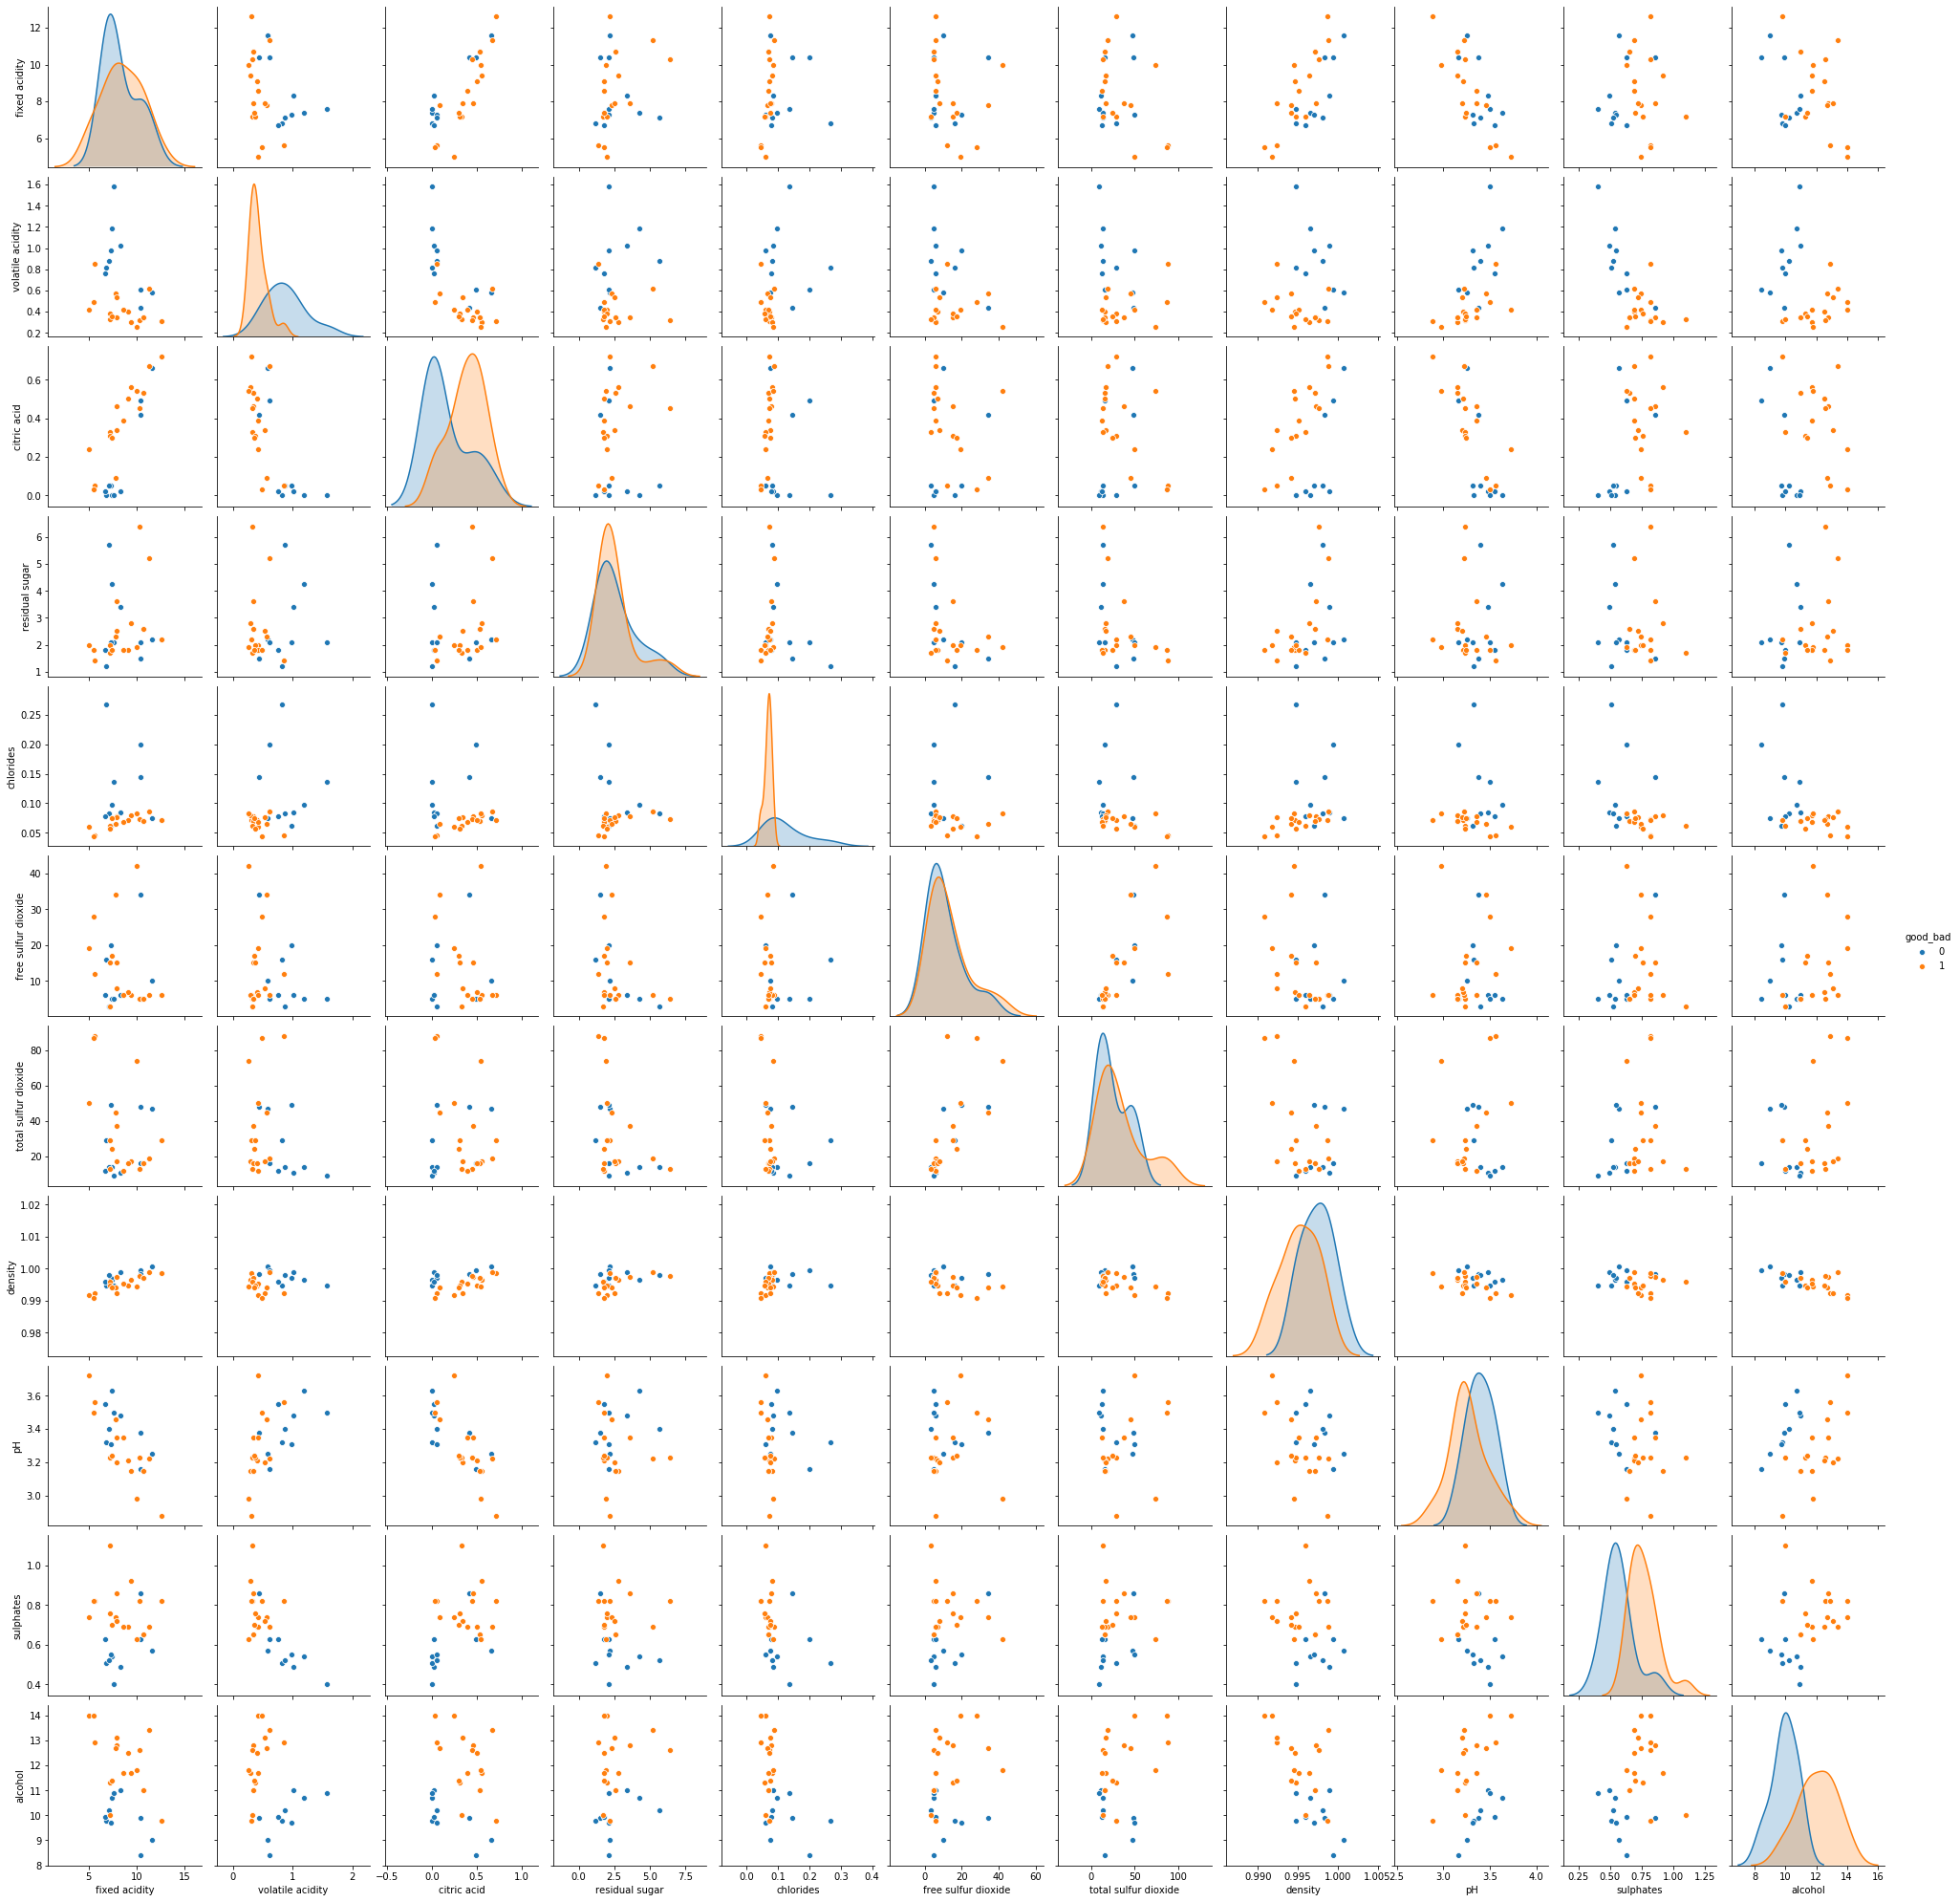

<Figure size 432x288 with 0 Axes>

In [2]:
def good_bad_column(wine_data, good_wine, bad_wine):
    good_bad_matrix = []
    for data in wine_data["quality"]:
        if data >= good_wine:
            good_bad_matrix.append(1)
        elif data <= bad_wine:
            good_bad_matrix.append(0)
        else:
            good_bad_matrix.append(2)
    return good_bad_matrix

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    wine_data.insert(loc=0, column="good_bad", value=good_bad_column(wine_data, good_threshold, bad_threshold))
    sorted_wine_data = wine_data.loc[wine_data["good_bad"] <= 1]
    features = ["good_bad", "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
    sns.pairplot(sorted_wine_data.loc[:, features], hue="good_bad")
    plt.show()
    if save_plot == True:
        plt.savefig('correlation.png')
        
file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
good = 8 # Put your value to be considered as good wine
bad = 3 # Put your value to be considered as bad wine
save_png = True
plot_scatter_matrix(df, good, bad, save_png)

## b)

The features that are the most likely to be useful during training of classifier are the following:
    1. volatile acidity
    2. chlorides
    3. alcohol

__We are looking for features that have very few correlations with other features, in this case we can see that chloride and acidity are both very distinctive. Alcohol is a bit less distinctive but we can still get something out of it. With very few samples like in this case, it's hard to clearly distinguish good from bad, but those are the few where it can be done.__
# V.2 Learning to perceptron
***
## a)
### Here I apply the method of merging the bias with the weights by adding a column "x_0"

In [3]:
def serie_to_array(serie):
    new_arr = []
    for e in serie:
        new_arr.append(e)
    return new_arr

def create_array(length, value):
    array = []
    for i in range(length):
        array.append(value)
    return array
    
def create_array_random(length):
    array = []
    for i in range(length):
        array.append(random.uniform(-1, 1))
    return array

def dot_product(w_list, x_list):
    dot_prod = 0
    for w, x in zip(w_list, x_list):
        dot_prod += (float(w) * float(x))
    return dot_prod

def heavside(neuron_value):
    if neuron_value >= 0:
        return 1
    return 0

def perceptron_rosenblatt_model(wine_data):
    features = ["x_0", "volatile acidity", "chlorides", "alcohol"]
    wine_data.insert(0, "x_0", create_array(len(wine_data), 1))
    wine_data = wine_data.loc[:, features]
    thetas = create_array_random(wine_data.shape[1])
    rosen_result = heavside(dot_product(thetas, serie_to_array(wine_data.iloc[1])))
    print(rosen_result)
    
file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
perceptron_rosenblatt_model(df)

1


## b)
### Here I use the bias (b + w1*x1 + ...) instead of merging it with the weights (w0*x0 + w1*x1 + ...)

In [5]:
def transpose_data(data):
    tot_arr = []
    for i in range(len(data)):
        new_arr = []
        for element in data.iloc[i]:
            new_arr.append(element)
        tot_arr.append(new_arr)
    return tot_arr

class rosenblattModel:
    def __init__(self, x, y, epochs=5000, learning_rate=0.5):
        self.x = transpose_data(x)
        self.y = serie_to_array(y)
        self.thetas = create_array_random(len(self.x[0]))
        self.bias = random.uniform(-1, 1)
        self.epochs = epochs
        self.learning_rate = learning_rate
        if epochs == 0:
            self.epochs = 8000
            self.learning_rate = 0.5
    
    def update_weights(self, error, param):
        new_thetas = []
        for w, x in zip(self.thetas, param):
             new_thetas.append(w + error * x)
        return new_thetas
    
    def predict_sample(self, thetas, x, bias):
        return heavside(dot_product(thetas, x) + bias)
    
    def train_model(self):
        performance = []
        for e in range(self.epochs):
            tot_err = 0
            for x, y in zip(self.x, self.y):
                error = self.learning_rate * (y - self.predict_sample(self.thetas, x, self.bias))
                if error != 0:
                    self.thetas = self.update_weights(error, x)
                    self.bias += error
                    tot_err += 1
            performance.append((e, tot_err, self.thetas, self.bias))
            if tot_err == 0:
                break
        return performance             

def normalize_data(data):
    data = (data - data.min()) / (data.max() - data.min())
    return data
    
def train_perceptron(wine_data, good, bad, normalize=False):
    wine_data.insert(loc=0, column="good_bad", value=good_bad_column(wine_data, good, bad))
    sorted_wine_data = wine_data.loc[wine_data["good_bad"] <= 1]
    if normalize == True:
        x = normalize_data(sorted_wine_data.loc[:, ["volatile acidity", "alcohol"]])
    else:
        x = sorted_wine_data.loc[:, ["volatile acidity", "alcohol"]]
    y = sorted_wine_data.loc[:, "good_bad"]
    rosen = rosenblattModel(x, y, 5000, 0.1).train_model()
    return rosen

file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
store = train_perceptron(df, 8, 3)

## c)

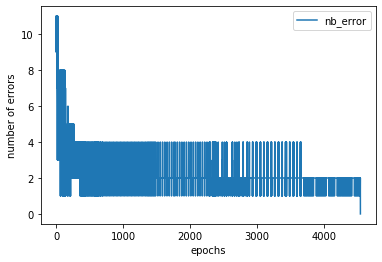

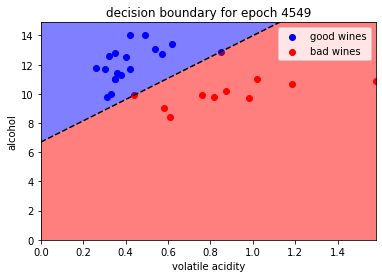

In [6]:
import decimal
import numpy as np
from operator import itemgetter

def plot_error_graph(perf):
    x = list(map(itemgetter(0), perf))
    y = list(map(itemgetter(1), perf))
    plt.plot(x, y, label="nb_error")
    plt.xlabel("epochs")
    plt.ylabel("number of errors")
    plt.legend()

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
    
def fit_data(list_x, thetas, bias):
    decision_x = []
    for x in list_x:
        decision_x.append(dot_product(thetas, x) + bias)
    return decision_x
    
def plot_decision_boundary(data, perf, epochs, normalize):
    plt.title("decision boundary for epoch " + str(itemgetter(0)(perf[epochs])))
    wine_data = data.loc[data["good_bad"] <= 1]
    good_wine_data = data.loc[data["good_bad"] == 1]
    bad_wine_data = data.loc[data["good_bad"] == 0]
    good_scatter_x = good_wine_data.loc[:, "volatile acidity"]
    good_scatter_y = good_wine_data.loc[:, "alcohol"]
    bad_scatter_x = bad_wine_data.loc[:, "volatile acidity"]
    bad_scatter_y = bad_wine_data.loc[:, "alcohol"]
    scatter_x = wine_data.loc[:, "volatile acidity"]
    scatter_y = wine_data.loc[:, "alcohol"]
    
    plt.xlabel("volatile acidity")
    plt.ylabel("alcohol")
    plt.scatter(good_scatter_x, good_scatter_y, color='b', label="good wines")
    plt.scatter(bad_scatter_x, bad_scatter_y, color='r', label="bad wines")
    
    weights = perf[epochs]
    thetas = itemgetter(-2)(weights)
    bias = itemgetter(-1)(weights)
    
    x_intercept = (-1 * bias) / thetas[0]
    y_intercept = (-1 * bias) / thetas[1]
    slope = (-1 * y_intercept) / x_intercept
    x = np.arange(0.0, 2.0, 0.1)
#     y = ((-1 * thetas[0] / thetas[1]) * x) - (bias / thetas[1]) -> with relationship
    y = (slope * x) + y_intercept
    plt.legend()
    plt.fill_between(x, y, -10000, facecolor='r', alpha=0.5)
    plt.fill_between(x, y, 10000, facecolor='b', alpha=0.5)
    plt.plot(x, y, color='black', linestyle='--')
    
def plot_rosenblatt(performance, wine_data, epochs=-1, save_plot=False, normalize=False):
    if normalize == True:
        wine_data.loc[:, ["volatile acidity", "alcohol"]] = normalize_data(wine_data.loc[:, ["volatile acidity", "alcohol"]])
    plt.figure(1)
    plot_error_graph(performance)
    plt.figure(2)
    plot_decision_boundary(wine_data, performance, epochs, normalize)
    if normalize == True:
        plt.xlim(0, 1.2)
        plt.ylim(0, 1.2)
    else:
        plt.xlim(0, wine_data.loc[:, "volatile acidity"].max())
        plt.ylim(0, wine_data.loc[:, "alcohol"].max())
    plt.show()
    if save_plot == True:
        plt.savefig('error_graph_and_decision_boundary.png')

file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
performance = train_perceptron(df, 8, 3)
plot_rosenblatt(performance, df)

## d)

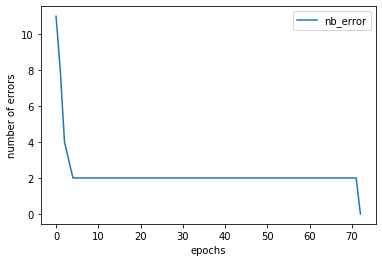

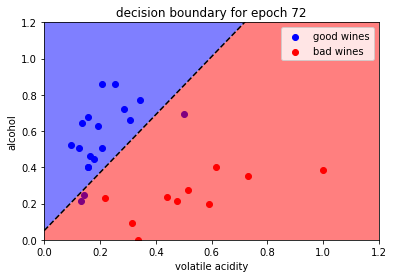

In [7]:
file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
performance = train_perceptron(df, 8, 3, True)
plot_rosenblatt(performance, df, -1, False, True)

# V.3 My fair ADALINE
***
## a)

Marvin is not happy because my simple perceptron will never arrive at a score of 0. The natural algorithm used to train the perceptron and minimize the error will only stop when the number of erros arrives at 0, but it never will.
**We can't have a perfect decision boundary with this data (proof below).**

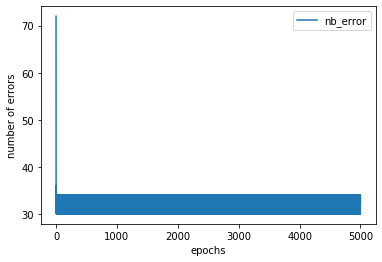

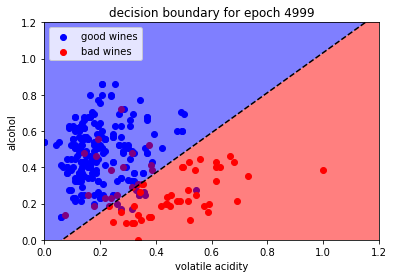

In [8]:
file = open("resources/winequality-red.csv")
df = pd.read_csv(file, sep=';')
performance = train_perceptron(df, 7, 4, True)
plot_rosenblatt(performance, df, -1, False, True)

## b) Adaline prediction with sigmoid activation function & heavside quantizer

In [9]:
def sigmoid_function(z):
    e = 2.71828182
    return 1 / ((1 + (e ** z)))

def adaline(thetas, parameters):
    return sigmoid_function(-1 * (dot_product(thetas, parameters)))

file = open("resources/winequality-red.csv")
wine_data = pd.read_csv(file, sep=';')

features = ["x_0", "volatile acidity", "chlorides", "alcohol"]
wine_data.insert(0, "x_0", create_array(len(wine_data), 1))
wine_data = wine_data.loc[:, features]
thetas = create_array_random(wine_data.shape[1])

print(heavside(adaline(thetas, wine_data.iloc[0])))

1


## c) Learning function for Adaline -> Stochastic Gradient Descent OR mini-batch

In [72]:
class gradientDescent():
    def __init__(self, data, good_bad_data, weights, epochs=-1, learning_rate=0.1, mini_batch=False):
        self.data = data
        self.good_bad_data = good_bad_data
        self.weights = weights
        self.epochs = epochs
        self.lr = learning_rate
        self.mini_batch = mini_batch
        
    def train_model(self):
        batch = 1
        if self.mini_batch == True:
            batch = 20
        max_batch = int(self.data.shape[0] / batch)
        print(max_batch)
        for e in range(self.epochs):
            error = 0
            for b in range(0, max_batch - 1):
                batch_of_data = self.data[b*batch:(b + 1)*batch]
                print(batch_of_data)
                z = dot_product(self.weights, batch_of_data)
                h = sigmoid_function(-z)
                gradient = (adaline(self.weights, batch_of_data) - (self.good_bad_data[b*batch:(b + 1)*batch])["good_bad"]) / batch
                self.weights -= self.lr * gradient
#                 print(b)
#         print(error)
        print(self.weights)
            
            
            
            
file = open("resources/winequality-red.csv")
wine_data = pd.read_csv(file, sep=';')

features = ["volatile acidity", "chlorides", "alcohol"]
good_bad_features = ["volatile acidity", "chlorides", "alcohol", "good_bad"]
wine_data.insert(loc=0, column="good_bad", value=good_bad_column(wine_data, 7, 4))
sorted_wine_data = (normalize_data(wine_data.loc[wine_data["good_bad"] <= 1])).loc[:, features]
sorted_wine_data.insert(0, "x_0", create_array(len(sorted_wine_data), 1))
wine_data = (normalize_data(wine_data.loc[wine_data["good_bad"] <= 1])).loc[:, good_bad_features]
wine_data.insert(0, "x_0", create_array(len(wine_data), 1))
weights = create_array_random(sorted_wine_data.shape[1])

gradientDescent(sorted_wine_data, wine_data, weights, 1, 0.1).train_model()

14
     x_0  volatile acidity  chlorides   alcohol
7      1          0.363014   0.088629  0.285714
8      1          0.315068   0.102007  0.196429
16     1          0.109589   0.133779  0.375000
18     1          0.321918   0.123746  0.107143
37     1          0.178082   0.090301  0.232143
38     1          0.691781   0.267559  0.250000
41     1          0.335616   0.127090  0.160714
45     1          0.273973   0.070234  0.839286
62     1          0.273973   0.122074  0.196429
73     1          0.380137   0.120401  0.142857
79     1          0.345890   0.113712  0.125000
94     1          0.616438   0.055184  0.375000
128    1          0.321918   0.088629  0.375000
151    1          0.273973   1.000000  0.178571
161    1          0.383562   0.100334  0.142857
167    1          0.294521   0.100334  0.107143
170    1          0.523973   0.076923  0.125000
198    1          0.489726   0.056856  0.821429
199    1          0.664384   0.081940  0.535714
200    1          0.136986   0.073579

ValueError: could not convert string to float: 'x_0'